In [1]:
# import osr_examples.scripts.environment_2d as environment_2d
import numpy as np
import pylab as pl
import sys
import heapq
from tqdm import tqdm
sys.path.append('osr_examples/scripts/')
import environment_2d
pl.ion()
np.random.seed(4)


# Probabilistic Road Maps

In [2]:
def generate_random_point(size_x = 10,size_y = 6):
    """
    Generate a random point on the board
    """
    temp = np.random.random(2)
    x = temp[0]*size_x
    y = temp[1]*size_y
    return x,y

In [3]:
def march(env: environment_2d.Environment, current_point, target_point, step_length = 0.1):
    """
    Determines the existence of a straight path between 2 points.
    Returns true if this path exists
    """
    distance = ((target_point[0]- current_point[0])**2 +  (target_point[1]- current_point[1])**2)**(1/2)
    num_steps = int(distance//step_length)
    step = (
        ((target_point[0]- current_point[0])/distance)*step_length,
        ((target_point[1]- current_point[1])/distance)*step_length
    )
    current_loc = current_point
    for step_num in range(num_steps):
        
        current_loc = (current_loc[0]+step[0],current_loc[1]+step[1])
        if env.check_collision(*current_loc):
            return False
    return True, distance

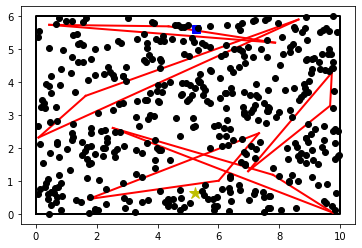

In [4]:
size_x = 10
size_y = 6
env = environment_2d.Environment(size_x, size_y, 5)
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)

    
    

# Sampling points
num_points_sampled = 500
sample_points = []
for x in range(num_points_sampled):
    point = generate_random_point()
    if not env.check_collision(*point):
        sample_points.append(point)
        pl.plot(*point,'ko')

# sample_points+= [(x_start,y_start),(x_goal,y_goal)]

## Some thoughts:
For a given point, in order to find its closest neighbors, we will have to
iterate through every other point and hence it will have a time complexity of O(n)
Hence to find the nearest neighbours of every point, it will take O(n^2)

This can be overcome by segmenting the grid into discreet tiles and storing the 
sample points present in each tile.

Using this 2D tile like data structure, we can iterate through a square window around
the current sample point of interest to find the nearest neighbors in O(n*num points in window)

In [5]:
# let each tile be of size 0.5*0.5
tile_size = 0.5

tiles = [[[] for y in range(size_y*int(1//tile_size))]for x in range(size_x*int(1//tile_size))]

In [6]:
for point in sample_points:
    tiles[int(point[0]//tile_size)][int(point[1]//tile_size)].append(point)

In [7]:
def extract_window(tiles,row_index,col_index,tile_window_size=5):
    """
    Extracts the elements in a square window around (row index, col index) with a given window size
    """
    points_in_window = []
    lower_bound_row = max(0,row_index-tile_window_size)
    upper_bound_row = min(len(tiles),row_index+tile_window_size+1)
    lower_bound_col = max(0,col_index-tile_window_size)
    upper_bound_col = min(len(tiles[0]),col_index+tile_window_size+1)

    for window_row_index in range(lower_bound_row,upper_bound_row):
        for window_col_index in range(lower_bound_col,upper_bound_col):
            points_in_window+= tiles[window_row_index][window_col_index]
    
    return points_in_window

In [8]:
tile_window_size = 3

completed = set()
graph = {}

for row_index, row in tqdm(enumerate(tiles),total = 20):
    for col_index, points in enumerate(row):
        
        # windowing around current tile
        candidate_points = extract_window(tiles,row_index,col_index, tile_window_size=tile_window_size)
        
        # extract the contents of each tile
        for point in points:
            
            for candidate_point in candidate_points:
                
                if (point,candidate_point) in completed or point == candidate_point:
                    continue
                march_result = march(env,point,candidate_point,step_length = 0.005)
                if march_result:
                    if point in graph:
                        graph[point].append((candidate_point,march_result[1]))
                    else:
                        graph[point]=[(candidate_point,march_result[1])]
                    
                    if candidate_point in graph:
                        graph[candidate_point].append((point,march_result[1]))
                    else:
                        graph[candidate_point]=[(point,march_result[1])]
                completed.add((candidate_point,point))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  3.05s/it]


In [9]:
def connect_start_and_goal(env: environment_2d.Environment, graph, start, goal,tile_size = 0.5):
    """
    Connect the start and goal node to the current graph(probabilistic road map)
    """
    start_tile_row = int(start[0]//tile_size)
    start_tile_col = int(start[1]//tile_size)
    goal_tile_row = int(goal[0]//tile_size)
    goal_tile_col = int(goal[1]//tile_size)
    
    start_candidate_children = extract_window(tiles,start_tile_row,start_tile_col)
    for start_candidate_point in start_candidate_children:
        march_result = march(env,start,start_candidate_point,step_length = 0.005)
        if march_result:
            if start in graph:
                graph[start].append((start_candidate_point,march_result[1]))
            else:
                graph[start]=[(start_candidate_point,march_result[1])]
            
            graph[start_candidate_point].append((start,march_result[1]))
    
    
    goal_candidate_children = extract_window(tiles,goal_tile_row,goal_tile_col)
    for goal_candidate_point in goal_candidate_children:
        march_result = march(env,goal,goal_candidate_point,step_length = 0.005)
        if march_result:
            if goal in graph:
                graph[goal].append((goal_candidate_point,march_result[1]))
            else:
                graph[goal]=[(goal_candidate_point,march_result[1])]
            
            graph[goal_candidate_point].append((goal,march_result[1]))
    
    return graph

In [10]:
graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))

In [11]:
def euclidean_distance(cur_node,goal_node):
    """
    Calculates the euclidean distance between two points.
    Used as a heuristic and to find the norm of vectors.
    """
    return ((goal_node[0]- cur_node[0])**2 +  (goal_node[1]- cur_node[1])**2)**(1/2)

In [12]:
def a_star(graph,start_node,goal_node):
    """
    Finds and returns a path, if it exists, between the start node and the goal node.
    """
    explored = {start_node}
    frontier = []

    for child_node,cost in graph[start_node]:

        heapq.heappush(
            frontier,
            (
                cost+euclidean_distance(child_node,goal_node),
                cost,
                child_node,
                [start_node,child_node]
            )
        )

    while frontier:
        _, g, current_node, path = heapq.heappop(frontier)

        if current_node in explored:
            continue
        if current_node == goal_node:
            print(g,path)
            return path
        explored.add(current_node)

        for child_node, edge_cost in graph[current_node]:

            if child_node not in explored:
                heapq.heappush(
                    frontier,
                    (
                        g+edge_cost+euclidean_distance(child_node,goal_node),
                        g+edge_cost,
                        child_node,
                        path+[child_node]
                    )
                )
    
    

In [13]:
path = a_star(graph,(x_start,y_start),(x_goal,y_goal))

17.168590787043737 [(5.279088234179204, 5.625429503705652), (7.528201954804129, 5.887259514787565), (8.887982067957124, 5.964675496721826), (8.100822671084135, 5.3572547713629675), (7.120073813513306, 4.750326647660016), (6.372521132989128, 4.42489001224903), (4.796878195669036, 3.6368652782291266), (3.2976213143304003, 2.944031471749077), (2.287939221170233, 2.5561065613520646), (1.6927356464293164, 1.0924500463004407), (1.4772701167278024, 0.36977456355970983), (2.888549243542371, 0.49028415319980123), (5.21696122444958, 0.6491602973233841)]


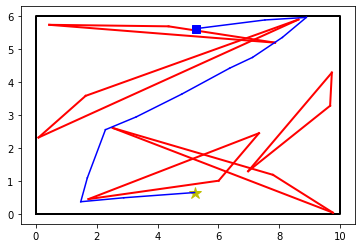

In [14]:
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")



# Path Shortcutting


In [15]:
def shorcut_path(path,max_reps = 1000):
    """
    Apply path shorcutting and return a shorter path
    """
    
    for _ in range(max_reps):

        num_edges = len(path)-1

        segment_1 = int(np.random.random()*num_edges)
        segment_2 = int(np.random.random()*num_edges)

        if segment_1 == segment_2:
            continue

        segment_1_start = path[segment_1]    
        segment_1_end = path[segment_1+1]
        segment_2_start = path[segment_2]    
        segment_2_end = path[segment_2+1]

        norm_1 = euclidean_distance(segment_1_start,segment_1_end)
        norm_2 = euclidean_distance(segment_2_start,segment_2_end)

        portion_1 = np.random.random()
        portion_2 = np.random.random()

        segment_1_step = ((segment_1_end[0]-segment_1_start[0]),(segment_1_end[1]-segment_1_start[1]))
        segment_2_step = ((segment_2_end[0]-segment_2_start[0]),(segment_2_end[1]-segment_2_start[1]))

        point_1 = (segment_1_start[0]+(segment_1_step[0]*portion_1),segment_1_start[1]+(segment_1_step[1]*portion_1))
        point_2 = (segment_2_start[0]+(segment_2_step[0]*portion_2),segment_2_start[1]+(segment_2_step[1]*portion_2))

        if march(env,point_1,point_2,step_length=0.005):
            if segment_1<segment_2:
                path = path[:segment_1+1]+[point_1,point_2]+path[segment_2+1:]
            elif segment_1>segment_2:
                segment_1,segment_2 = segment_2,segment_1
                path = path[:segment_1+1]+[point_2,point_1]+path[segment_2+1:]

    return path

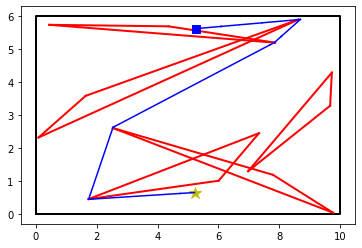

In [16]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

# Issues
- If the obstacle gets too small/ too thin, the algorithm will fail to
detect a collision and hence will allow the path to travel through an obstacle
- This could be overcome by using an algorithm to check the intersection of two lines
- There exists a trade off concerning the accuracy of a solution versus 
the time the solution takes to be computed. This is because, if we use smaller step sizes in the 
marching function, we can more accurately determine collisions, but the smaller the step size, 
the longer the algorithm takes to run

18.249399334109164 [(0.33238989006379893, 2.579508382562749), (0.061542830025934636, 5.375686591732041), (0.09607142020780723, 5.54632698523041), (0.7547675281413635, 5.950823967712882), (1.6526104868769964, 5.938915541194405), (3.042662473306361, 5.94315715787314), (3.8020313487194315, 5.830068022608929), (5.007160870497286, 5.7306081809473755), (6.759230599713343, 5.781915528398896), (7.528201954804129, 5.887259514787565), (8.887982067957124, 5.964675496721826), (8.100822671084135, 5.3572547713629675), (7.120073813513306, 4.750326647660016), (5.757778363336588, 4.336377353356905), (3.16219764233715, 3.3813032277277784)]


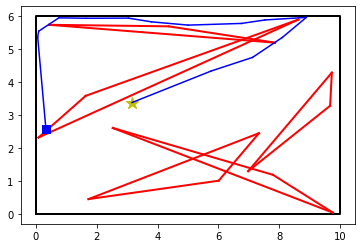

In [17]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")


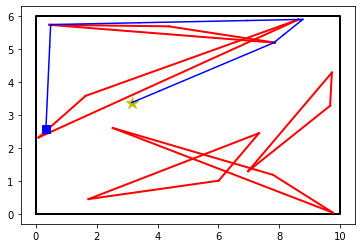

In [18]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

4.2933886596447115 [(8.199847611011839, 2.9385723094125087), (9.759052816075155, 4.419001583779613), (9.594904471600943, 2.2819757379826644)]


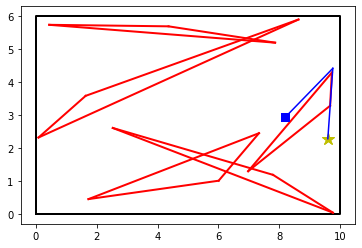

In [19]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

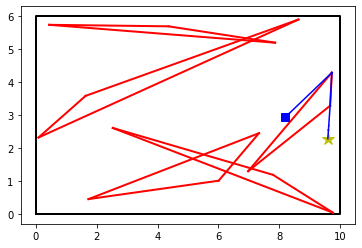

In [20]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

14.82716519141789 [(3.009288367370914, 5.540225781385666), (1.3617425128557037, 5.469036718737038), (0.09607142020780723, 5.54632698523041), (0.7547675281413635, 5.950823967712882), (1.6526104868769964, 5.938915541194405), (3.042662473306361, 5.94315715787314), (3.8020313487194315, 5.830068022608929), (5.007160870497286, 5.7306081809473755), (6.759230599713343, 5.781915528398896), (7.528201954804129, 5.887259514787565), (8.887982067957124, 5.964675496721826), (6.7691994849282295, 3.867508333089175)]


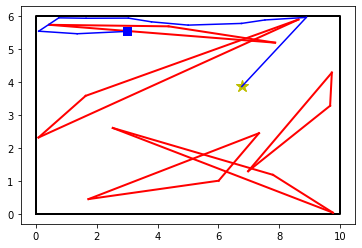

In [21]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

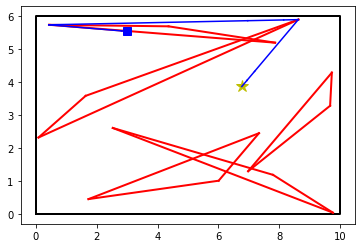

In [22]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

14.43576882364329 [(1.4743186811951703, 2.59917425490052), (3.639773224660435, 3.4641821927458754), (5.345126066065918, 4.06721071695732), (6.372521132989128, 4.42489001224903), (7.120073813513306, 4.750326647660016), (8.100822671084135, 5.3572547713629675), (8.887982067957124, 5.964675496721826), (7.528201954804129, 5.887259514787565), (6.759230599713343, 5.781915528398896), (5.007160870497286, 5.7306081809473755), (2.6558374099665105, 5.82767877264905)]


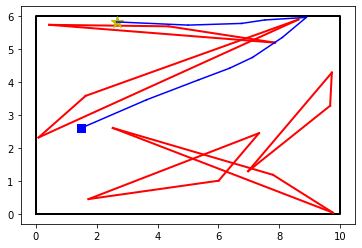

In [23]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

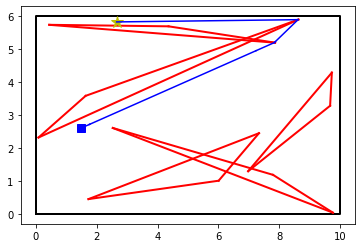

In [24]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

0.8909109315010306 [(0.9559797871365983, 0.15552250346567909), (0.5111589136696104, 0.27307467899771365), (0.10180991917132065, 0.40738344289365047)]


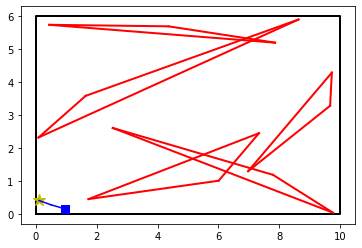

In [25]:
# other queries
q = env.random_query()
if q is not None:
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    graph = connect_start_and_goal(env,graph,(x_start,y_start),(x_goal,y_goal))
    path = a_star(graph,(x_start,y_start),(x_goal,y_goal))
    env.plot()
    x_start, y_start, x_goal, y_goal = q
    env.plot_query(x_start, y_start, x_goal, y_goal)
    for ind in range(len(path)-1):
        pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")

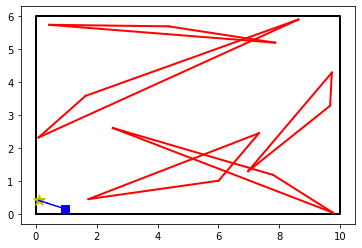

In [26]:
path= shorcut_path(path)
env.plot()
x_start, y_start, x_goal, y_goal = q
env.plot_query(x_start, y_start, x_goal, y_goal)
for ind in range(len(path)-1):
    pl.plot([path[ind][0],path[ind+1][0]],[path[ind][1],path[ind+1][1]],"b")